In [155]:
from qutip import *

from scipy.optimize import curve_fit as cf

import numpy as np
from numpy import pi as pi
from numpy import sqrt as sqrt

import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

In [156]:
def Rs(t,p):
    t = t/180*np.pi
    p = p/180*np.pi
    return np.array([np.sin(t)*np.cos(p), np.sin(t)*np.sin(p), np.cos(t)])    

def Rx(tx):
    tx = tx/180*np.pi
    Rx = np.array([[1,0,0],
                   [0,np.cos(tx),-np.sin(tx)],
                   [0,np.sin(tx), np.cos(tx)]])
    return Rx

def Rz(tz):
    tz= tz/180*np.pi
    Rz = np.array([[np.cos(tz), -np.sin(tz), 0],
                   [np.sin(tz), np.cos(tz), 0],
                   [0, 0, 1]])    
    return Rz

def Eigenbasis_Expansion(H):
    Q = np.zeros(H.shape, dtype=np.complex)
    for i, ev in enumerate(H.eigenstates()[1]):    
        Q[:,i] = ev.full().flatten()    
    return Q

In [209]:
def boltzmann(E, T):
    h = 6.626e-34
    kB = 1.38e-23
    return np.exp(-h*E/(kB*T))

def coth(gs, T):
    h = 6.626e-34
    kB = 1.38e-23
    return np.tanh(h*gs*1e9/(2*kB*T))**(-1)

def lorentzian(nu, nu0, Gamma, A, c):
    return A*(Gamma/2)**2/((nu-nu0)**2+(Gamma/2)**2) + c 

def gaussian(nu, nu0, sigma, A, c):
    return A*1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(nu-nu0)**2/(2*sigma**2)) + c

def pulse_seq(t, width, t0=0, tau=0, N=1):
    seq = np.zeros(t.shape)
    starts = []
    stops = []
    for n in range(N):
        starts.append(t0)
        stops.append(t0+width)
        seq += np.where( (t>=t0)&(t<t0+width), 1, 0)        
        t0 = t0 + width
        t0 += (n+1)*tau
    
    starts = np.array(starts)
    stops = np.array(stops)
    return starts, stops, seq

In [210]:
egx = basis(4, 0)
egy = basis(4, 1)
eux = basis(4, 2)
euy = basis(4, 3)

sgx = egx*egy.dag()
sgx += sgx.dag()
sgy = -1j*egx*egy.dag()
sgy += sgy.dag()
sgz = egx*egx.dag() - egy*egy.dag()
sux = eux*euy.dag()
sux += sux.dag()
suy = -1j*eux*euy.dag()
suy += suy.dag()
suz = eux*eux.dag() - euy*euy.dag()

egp = 1/np.sqrt(2)*(egx + 1j*egy)
egm = 1/np.sqrt(2)*(egx - 1j*egy)
eup = 1/np.sqrt(2)*(eux + 1j*euy)
eum = 1/np.sqrt(2)*(eux - 1j*euy)

su = basis(2,0)
sd = basis(2,1)
Sx = su*sd.dag() + sd*su.dag()
Sy = -1j*su*sd.dag() + 1j*sd*su.dag()
Sz = su*su.dag() - sd*sd.dag()

Iu = basis(2,0)
Id = basis(2,1)
Ix = Iu*Id.dag() + Id*Iu.dag()
Iy = -1j*Iu*Id.dag() + 1j*Id*Iu.dag()
Iz = Iu*Iu.dag() - Id*Id.dag()

In [211]:
sgx = tensor(sgx, qeye(2))
sgy = tensor(sgy, qeye(2))
sgz = tensor(sgz, qeye(2))
sux = tensor(sux, qeye(2))
suy = tensor(suy, qeye(2))
suz = tensor(suz, qeye(2))
Sx = tensor(qeye(4), Sx)
Sy = tensor(qeye(4), Sy)
Sz = tensor(qeye(4), Sz)

# Ix = tensor(qeye(4), qeye(2), Ix)
# Iy = tensor(qeye(4), qeye(2), Iy)
# Iz = tensor(qeye(4), qeye(2), Iz)

In [212]:
sigm_x = egp*eum.dag() + egm*eup.dag()
sigm_x = tensor(sigm_x, qeye(2))
sigp_x = sigm_x.dag()
px = sigm_x+sigp_x

sigm_y = 1j*egp*eum.dag() -1j* egm*eup.dag()
sigm_y = tensor(sigm_y, qeye(2))
sigp_y = sigm_y.dag()
py = sigm_y+sigp_y

sigm_z = 2*(egp*eup.dag() + egm*eum.dag())
sigm_z = tensor(sigm_z, qeye(2))
sigp_z = sigm_z.dag()
pz = sigm_z + sigp_z

In [213]:
h = 6.626e-34
c = 299792458
e = 1.62e-19
T = 5

# Bare coulomb splitting of Eg and Eu states
w_C = 2*pi*c/736.85

# Spin-orbit couplings
lbd_SO_g = 2*pi*46
lbd_SO_u = 2*pi*250

# (Transverse) Strain couplings
alpha_g = 2*pi*50
beta_g = 2*pi*50

alpha_u = 2*pi*1.8/1.3*alpha_g
beta_u = 2*pi*2*beta_g

# Magnetons and gyromagnetic ratio for electron and nuclear spin
muB = 2*pi*9.274e-24/h * 1e-9
muN = 2*pi*5.505e-23/h * 1e-9
g_e = 2
g_n = 1.910*0

# Orbital angular momentum quenching factor (phenomenological)
q = 0.15

# Nuclear spin coupling strengths along and perpendicular to the electron spin quantization axis 
# (which might be different from the SiV symmmetry axis)
A_para = 0*50e-3
A_perp = 0*100e-3

# SiV orientation (theta, phi) with respect to external lab frame, where z defines the optical axis
# theta_x = 54.7 and theta_z = 45 corresponds to a <111> crystal direction
theta_x = 54.7
theta_z = 45

# We can use a transformation matrix which transforms coordinates such that 111 --> 001, i.e. in this reference
# frame the SiV symmetry axis is pointing along z
Rz(-theta_z)@Rx(-theta_x)

array([[ 0.70710678,  0.40860704,  0.57709642],
       [-0.70710678,  0.40860704,  0.57709642],
       [ 0.        , -0.81613759,  0.57785762]])

Groundstate splitting:  45.99999999998052
Excited state splitting:  249.99999999999966
[-1278666.60937535 -1278624.71886893 -1277733.54201619 -1277688.89050184
  1275296.30554464  1275338.50640579  1281017.15298958  1281061.79582229]
5-4 Splitting:  6.716475654190751
3-2 Splitting:  7.106509226448262
1-0 Splitting:  6.6670811660410125
2-0 Splitting:  148.50228244718903


c:\program files (x86)\python36\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


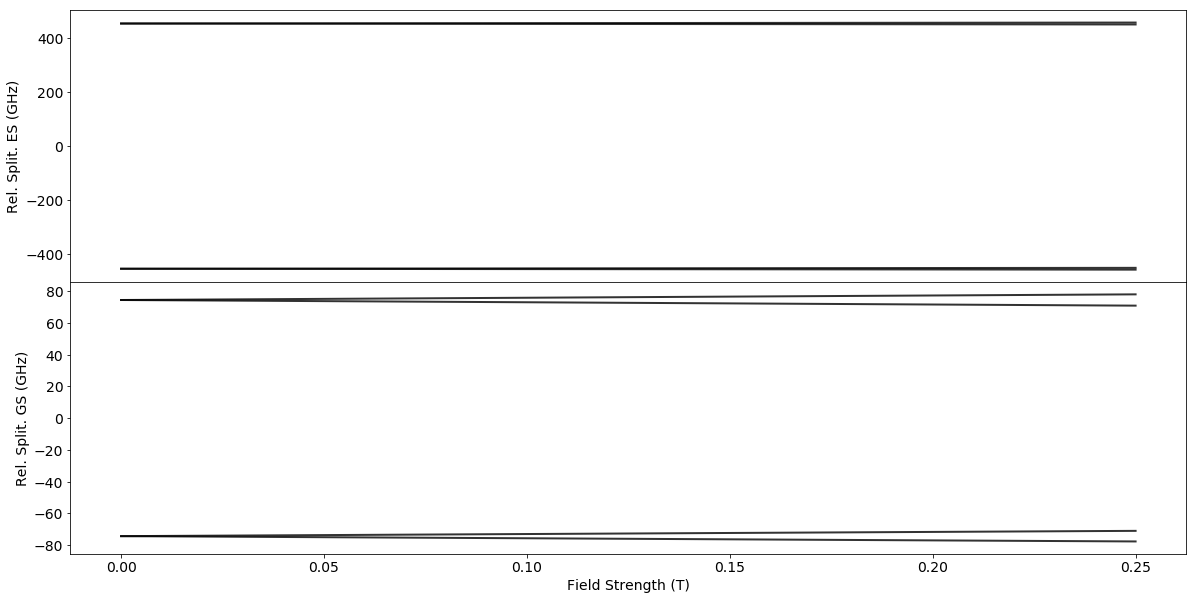

In [214]:
# Magnetic field orienttion with respect to external lab frame, where z defines the optical axis
B_theta, B_phi = 54.7+35, 40
Bs = np.linspace(0, 0.25, 25)
engs = np.zeros( (len(Bs), sgx.shape[0]) )

# Transform Bfield vector into reference frame 
bx, by, bz = Rx(theta_x)@Rz(theta_z)@Rs(B_theta, B_phi)

for i, B in enumerate(Bs):
    Bx = B*bx
    By = B*by
    Bz = B*bz    
    
    HC = w_C/2*tensor(eux*eux.dag() + euy*euy.dag() - egx*egx.dag() - egy*egy.dag(), qeye(2))
    
    HSO = lbd_SO_g/2 * sgy * Sz + lbd_SO_u/2 * suy * Sz
    
    HZS = g_e * muB/2 * (Sx * Bx + Sy * By + Sz * Bz)
    HZL = q * muB * (sgy + suy) * Bz
    
    HStr = alpha_g*sgz + beta_g*sgx + alpha_u*suz + beta_g*sux
    
    H = HC + HSO + HZS + HZL + HStr    
    H = H.tidyup(1e-10)
    
    engs[i, :] = H.eigenstates()[0]     

    
gs = 0.5 * abs((tensor(egm.dag(), su.dag())*H*tensor(egm, su) - tensor(egp.dag(), su.dag())*H*tensor(egp, su))[0,0])
gs += 0.5 * abs((tensor(egp.dag(), sd.dag())*H*tensor(egp, sd) - tensor(egm.dag(), sd.dag())*H*tensor(egm, sd))[0,0])
print("Groundstate splitting: ", gs/(2*np.pi))
es = 0.5 * abs((tensor(eum.dag(), su.dag())*H*tensor(eum, su) - tensor(eup.dag(), su.dag())*H*tensor(eup, su))[0,0])
es += 0.5 * abs((tensor(eup.dag(), sd.dag())*H*tensor(eup, sd) - tensor(eum.dag(), sd.dag())*H*tensor(eum, sd))[0,0])
print("Excited state splitting: ", es/(2*np.pi))

print(engs[-1,:])
print("5-4 Splitting: ", (engs[-1,5] - engs[-1,4])/(2*pi))
print("3-2 Splitting: ", (engs[-1,3] - engs[-1,2])/(2*pi))
print("1-0 Splitting: ", (engs[-1,1] - engs[-1,0])/(2*pi))
print("2-0 Splitting: ", (engs[-1,2] - engs[-1,0])/(2*pi))

fig, axs = plt.subplots(2,1, figsize=(20,10), sharex=True, squeeze=True)
for j in range(int(engs.shape[1]/2)):    
    
    axs[0].plot(Bs, (engs[:,j+int(engs.shape[1]/2)]-w_C/2)*1/(2*pi), color='k', alpha=0.8, lw=2)
    axs[1].plot(Bs, (engs[:,j]+w_C/2)*1/(2*pi), color='k', alpha=0.8, lw=2)

axs[1].set_ylabel("Rel. Split. GS (GHz)")
axs[1].set_xlabel("Field Strength (T)")
axs[0].set_ylabel("Rel. Split. ES (GHz)")
plt.subplots_adjust(wspace=0, hspace=0)

In [232]:
def init_cops(H, T, T1orb_g0=40, T1orb_u0=0.4, T1spin=1e3, T1opt=1.7):
    gs = 0.5 * abs((tensor(egm.dag(), su.dag())*H*tensor(egm, su) - tensor(egp.dag(), su.dag())*H*tensor(egp, su))[0,0])
    gs += 0.5 * abs((tensor(egp.dag(), sd.dag())*H*tensor(egp, sd) - tensor(egm.dag(), sd.dag())*H*tensor(egm, sd))[0,0])
    print("Groundstate splitting: ", gs/(2*np.pi))
    print("Strain splitting: ", abs(tensor(egm.dag(), qeye(2))*H*tensor(egm, qeye(2)) - tensor(egp.dag(), qeye(2))*H*tensor(egp, qeye(2)))[0,0]/(2*pi))
    es = 0.5 * abs((tensor(eum.dag(), su.dag())*H*tensor(eum, su) - tensor(eup.dag(), su.dag())*H*tensor(eup, su))[0,0])
    es += 0.5 * abs((tensor(eup.dag(), sd.dag())*H*tensor(eup, sd) - tensor(eum.dag(), sd.dag())*H*tensor(eum, sd))[0,0])
    print("Excited state splitting: ", es/(2*np.pi))

    Gamma_opt = 1/(2*pi*1.73)
    Gamma_phon_g0 = 1/(2*pi*40)
    Gamma_phon_u0 = 1/(2*pi*0.4)
    Gamma_spin = 1/(2*pi*1e3)

    gs0 = lbd_SO_g
    # gs = tensor(egp*egm.dag(),su*su.dag()) /(2*pi)
    # es = (engs[-1,6]-engs[-1,4])/(2*pi)

    Gamma_phon_g = Gamma_phon_g0*(gs/gs0)**3 * coth(gs,T) / coth(gs0,T)
    Gamma_phon_g = Gamma_phon_g
    print("Extrapolated T1: ", 1/(2*pi*Gamma_phon_g))

    es0 = lbd_SO_u
    Gamma_phon_u = Gamma_phon_u0*(es/es0)**3 * coth(es,T) / coth(es0,T)

    c_ops = []

    # Optical decays defined from SO basis (only Emission relevant)
    c_ops.append(np.sqrt(Gamma_opt)*sigm_x)
    c_ops.append(np.sqrt(Gamma_opt)*sigm_y)
    c_ops.append(np.sqrt(Gamma_opt)*sigm_z)

    # Phononic relaxation
    # Emission
    c_ops.append(np.sqrt(1/(boltzmann(gs*1e9, T)+1)*Gamma_phon_g) * (tensor(egp*egm.dag(),su*su.dag()) + tensor(egm*egp.dag(), sd*sd.dag())))
    c_ops.append(np.sqrt(1/(boltzmann(es*1e9, T)+1)*Gamma_phon_u) * (tensor(eup*eum.dag(),su*su.dag()) + tensor(eum*eup.dag(), sd*sd.dag())))

    # Absorption
    c_ops.append(np.sqrt(boltzmann(gs*1e9, T)/(boltzmann(gs*1e9, T)+1)*Gamma_phon_g) * (tensor(egp*egm.dag(),sd*sd.dag()) + tensor(egm*egp.dag(),su*su.dag())))
    c_ops.append(np.sqrt(boltzmann(es*1e9, T)/(boltzmann(es*1e9, T)+1)*Gamma_phon_u) * (tensor(eup*eum.dag(),sd*sd.dag()) + tensor(eum*eup.dag(),su*su.dag())))

    #Spin relaxation
    # c_ops.append(np.sqrt(Gamma_spin)*tensor(egm*egp.dag() + egp*egm.dag() + eum*eup.dag() + eup*eum.dag(), sd*su.dag()))
    # c_ops.append(np.sqrt(Gamma_spin)*tensor(egp*egm.dag() + egm*egp.dag() + eum*eup.dag() + eup*eum.dag(), su*sd.dag())) 
    c_ops.append(np.sqrt(Gamma_spin)*tensor(qeye(4), sd*su.dag()))
    c_ops.append(np.sqrt(Gamma_spin)*tensor(qeye(4), su*sd.dag())) 
    
    return c_ops

def calc_transitions(H):
    trans_engs = np.zeros(H.shape)
    trans_dipoles = np.zeros(H.shape)

    engs_ = H.eigenstates()[0]
    evs_ = H.eigenstates()[1]

    for i, engi in enumerate(engs_):
        for j, engj in enumerate(engs_[:i]):         
            if round(abs(engi-engj),3)<1e4: continue
            trans_engs[i,j] = abs(engi-engj)
            trans_dipoles[i,j] = abs((evs_[i].dag() * px * evs_[j])[0,0])**2 + abs((evs_[i].dag() * py * evs_[j])[0,0])**2 + abs((evs_[i].dag() * pz * evs_[j])[0,0])**2

    # transitions = list(sorted(set(trans_engs[trans_engs.nonzero()])))
    transitions = np.array(list(sorted(trans_engs[trans_engs.nonzero()])))

    D = transitions[0*len(transitions)//4:1*len(transitions)//4]
    C = transitions[1*len(transitions)//4:2*len(transitions)//4]
    B = transitions[2*len(transitions)//4:3*len(transitions)//4]
    A = transitions[3*len(transitions)//4:4*len(transitions)//4]
    
    return A, B, C, D

def Hamiltonian(B, B_phi, B_theta, alpha, beta):
    # Transform Bfield vector into reference frame 
    bx, by, bz = Rx(theta_x)@Rz(theta_z)@Rs(B_theta, B_phi)
    Bx = B*bx
    By = B*by
    Bz = B*bz
    HC = w_C/2*tensor(eux*eux.dag() + euy*euy.dag() - egx*egx.dag() - egy*egy.dag(), qeye(2))

    HSO = -lbd_SO_g/2 * sgy * Sz -lbd_SO_u/2 * suy * Sz

    HZS = g_e * muB/2 * (Sx * Bx + Sy * By + Sz * Bz)
    HZL = -0.13 * muB * (-sgy - suy) * Bz

    HStr = alpha_g*sgz + beta_g*sgx + alpha_u*suz + beta_g*sux

    H = HC + HSO + HZS + HZL + HStr    
    H = H.tidyup(1e-10)

    return H

def calc_spec(H, c_ops, transition, Omega_L, eps_L=[1,1,1]):
    eps_x, eps_y, eps_z = eps_L

    # w_Ls = np.linspace(-50+min(transitions), max(transitions)+50, 2000)
    w_Ls = np.linspace(-10+transition[0], transition[3]+10, 500)
    pops = np.zeros((len(w_Ls), 4))
    for i, w_L in enumerate(w_Ls):    

        Hint = Omega_L/2*(eps_x*px + eps_y*py + eps_z*pz) - (w_L)/2 * HC/(w_C/2)
        Hint = Hint.tidyup()

        rho_ss = steadystate(H+Hint, c_ops)

        pops[i,0] = np.real(rho_ss[4,4])
        pops[i,1] = np.real(rho_ss[5,5])
        pops[i,2] = np.real(rho_ss[6,6])
        pops[i,3] = np.real(rho_ss[7,7])
    return pops

Groundstate splitting:  45.99999999996199
Strain splitting:  (45.228039169117416+0j)
Excited state splitting:  249.99999999999966
Extrapolated T1:  40.00000000008768


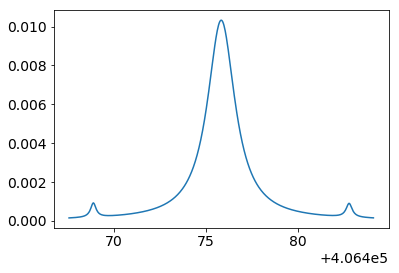

In [253]:
B = 0.3
B_phi = 45
B_theta = 54.7+45
alpha = 0
beta = 0
Omega_L = 1
eps_L = [1,1,1]

H = Hamiltonian(B, B_phi, B_theta, alpha, beta)
c_ops = init_cops(H, T)

A, B, C, D = calc_transitions(H)
pops = calc_spec(H, c_ops, C, Omega_L, eps_L)

plt.plot(w_Ls/(2*pi), np.sum(pops,axis=1))
p0 = (w_Ls[np.argmax(pops_tot)]/(2*pi), Gamma_opt, np.amax(pops_tot), 0)
fit_func = lorentzian
popt, pcov = cf(fit_func, w_Ls/(2*pi), pops_tot, p0=p0)